In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fpt-ai-residency-batch-6-entry-test/sample_submission.csv
/kaggle/input/fpt-ai-residency-batch-6-entry-test/b6_test_data.csv
/kaggle/input/fpt-ai-residency-batch-6-entry-test/b6_train_data.csv
/kaggle/input/fpt-ai-residency-batch-6-entry-test/archived/archived/b6_test_data.csv
/kaggle/input/fpt-ai-residency-batch-6-entry-test/archived/archived/b6_train_data.csv
/kaggle/input/llama-3.2/transformers/3b-instruct/1/model.safetensors.index.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/config.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/model-00001-of-00002.safetensors
/kaggle/input/llama-3.2/transformers/3b-instruct/1/model-00002-of-00002.safetensors
/kaggle/input/llama-3.2/transformers/3b-instruct/1/README.md
/kaggle/input/llama-3.2/transformers/3b-instruct/1/USE_POLICY.md
/kaggle/input/llama-3.2/transformers/3b-instruct/1/tokenizer.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/tokenizer_config.json
/kaggle/input/llama-3.2/transformers/3b-instru

# Installing and Importing

In [2]:
%%capture
%pip install -U transformers accelerate
%pip install -U transformers 
%pip install -U datasets 
%pip install -U accelerate 
%pip install -U peft 
%pip install -U trl 
%pip install -U wandb


In [3]:
%pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 23.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
from datasets import Dataset, concatenate_datasets
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch, wandb
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from wordcloud import WordCloud
import ast
from trl import SFTTrainer, setup_chat_format, SFTConfig
import bitsandbytes as bnb


In [5]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HuggingFace")
login(token = hf_token)

In [6]:
wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Finetuning Llama 3.2 using CodeMMLU dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ferrum0404 (ferrum0404-fpt-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.8
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250330_174050-u6a5f884
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wild-brook-8
wandb: ⭐️ View project at https://wandb.ai/ferrum0404-fpt-university/Finetuning%20Llama%203.2%20using%20CodeMMLU%20dataset?apiKey=7b642bd7309754ea74bf7bbff699572f99f0245b
wandb: 🚀 View run at https://wand

# Loading Dataset

In [7]:
train_path = '/kaggle/input/fpt-ai-residency-batch-6-entry-test/b6_train_data.csv'
test_path = '/kaggle/input/fpt-ai-residency-batch-6-entry-test/b6_test_data.csv'


In [8]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()


,task_id,question,choices,answer
0,k10168,Question: What will be output of the following...,"['8 4 2', '8 4 2', '8 4 4', '8 4 3']",C
1,k10173,Question: What will be output of the following...,"['-4', '-5', '10', '11']",A
2,k10174,Question: Match the following.\n Group 1 ...,"['P-4. Q-1, R-2, S-3', 'P-3, Q-1, R-4, S-2', '...",B
3,k10175,Question: Match the following.\nP. Regular exp...,"['P-4. Q-1, R-2, S-3', 'P-3, Q-1, R-4, S-2', '...",B
4,k10176,Question: Which grammar rules violate the requ...,"['1 only', '1 and 3 only', '2 and 3 only', '3 ...",B


# Exploratory Data Analysis

In [9]:
print('Train Set: ')
print('Number of questions: ', train_df.shape[0])
print('Numbers of feature: ', train_df.shape[1])

train_df.info()


Train Set: 
Number of questions:  3963
Numbers of feature:  4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3963 entries, 0 to 3962
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   task_id   3963 non-null   object
 1   question  3963 non-null   object
 2   choices   3963 non-null   object
 3   answer    3949 non-null   object
dtypes: object(4)
memory usage: 124.0+ KB


In [10]:
missing_data = train_df.isnull().sum()
print("Missing values:\n", missing_data)


Missing values:
 task_id      0
question     0
choices      0
answer      14
dtype: int64


We have 14 missing entries in "answer" column.

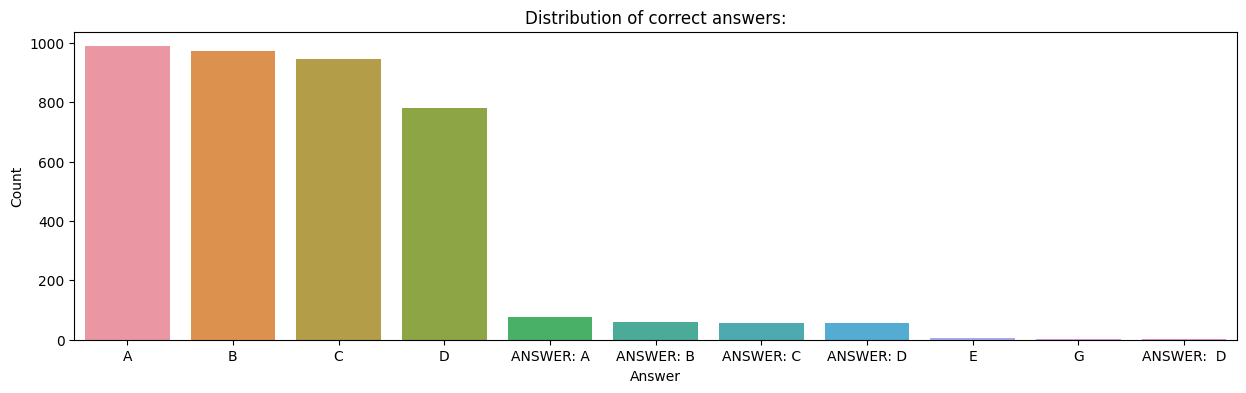

In [11]:
answer_dist = train_df['answer'].value_counts()

plt.figure(figsize=(15, 4))
sns.barplot(x=answer_dist.index, y=answer_dist.values)
plt.title("Distribution of correct answers:")
plt.xlabel("Answer")
plt.ylabel("Count")
plt.show()


Beside A, B, C, D. There are still other options such as E or G. Besides, some answers have the illegal format for training.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


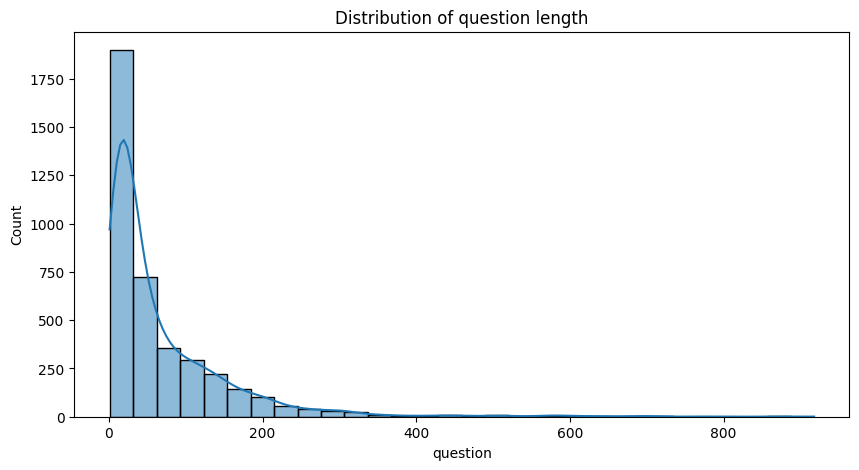

In [12]:
question_word_count = train_df['question'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(question_word_count, bins=30, kde=True)
plt.title("Distribution of question length")
plt.show()


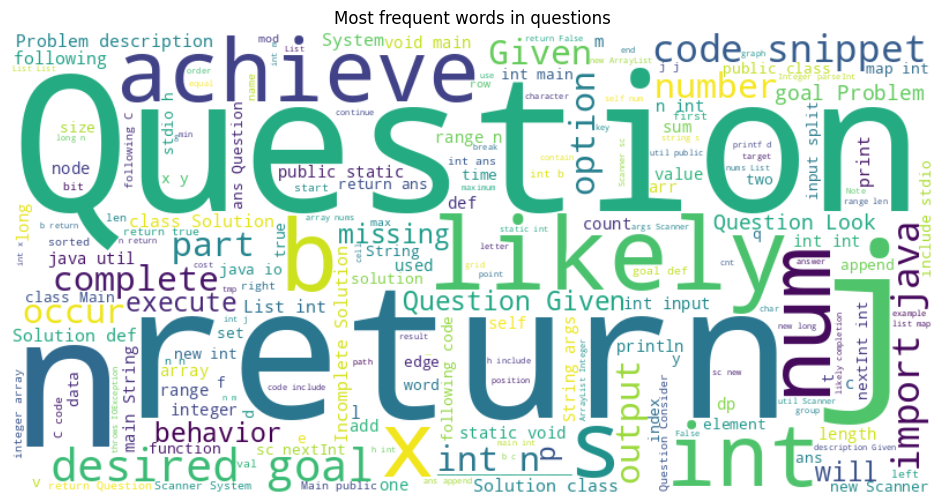

In [13]:
text = " ".join(train_df['question'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words in questions")
plt.show()


The graph looks kinda cools, ain't it?

Average number of choices for each question:  3.9157204138279083


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


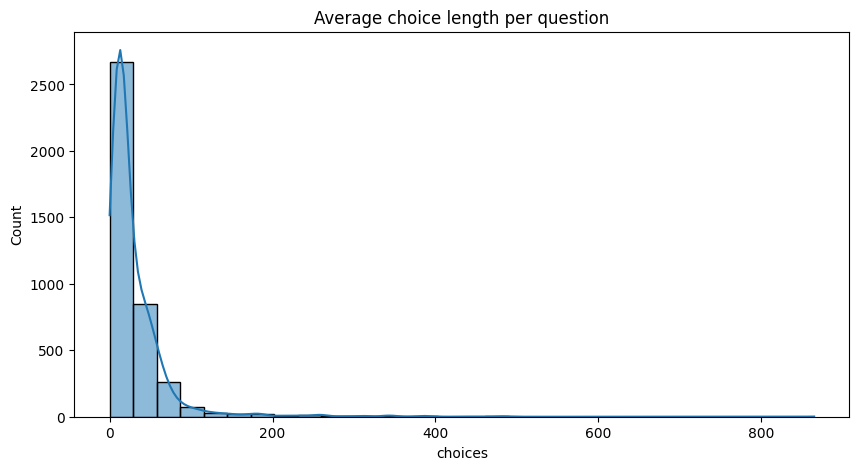

In [14]:
num_choices = train_df['choices'].apply(lambda x: len(eval(x)))

print("Average number of choices for each question: ", num_choices.mean())

def avg_choice_length(choices_list):
    if len(choices_list) == 0:
        return 0
    return sum(len(choice) for choice in choices_list) / len(choices_list)

avg_choice_length = train_df['choices'].apply(lambda x: avg_choice_length(eval(x)))

plt.figure(figsize=(10, 5))
sns.histplot(avg_choice_length, bins=30, kde=True)
plt.title("Average choice length per question")
plt.show()


Most questions are 4-answer mutiple-choice questions. \
Choices' length was longer than questions' length at some extent.

# Pre-processing Dataset

In [15]:
# Delete rows with null values in the 'answer' column
train_df_cleaned = train_df.dropna(subset=['answer'])

missing_data = train_df_cleaned.isnull().sum()
print("Missing values:\n", missing_data)


Missing values:
 task_id     0
question    0
choices     0
answer      0
dtype: int64


In [16]:
# Replace the "ANSWER: " format
train_df_cleaned['answer'] = train_df_cleaned['answer'].str.replace("ANSWER: ", "", regex=False)
train_df_cleaned['answer'] = train_df_cleaned['answer'].str.replace(" ", "", regex=False)

print(train_df_cleaned['answer'].unique())  # Expected values: ['A', 'B', 'C', 'D']


['C' 'A' 'B' 'D' 'E' 'G']


<ipython-input-16-7140acb8a19c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned['answer'] = train_df_cleaned['answer'].str.replace("ANSWER: ", "", regex=False)
<ipython-input-16-7140acb8a19c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned['answer'] = train_df_cleaned['answer'].str.replace(" ", "", regex=False)


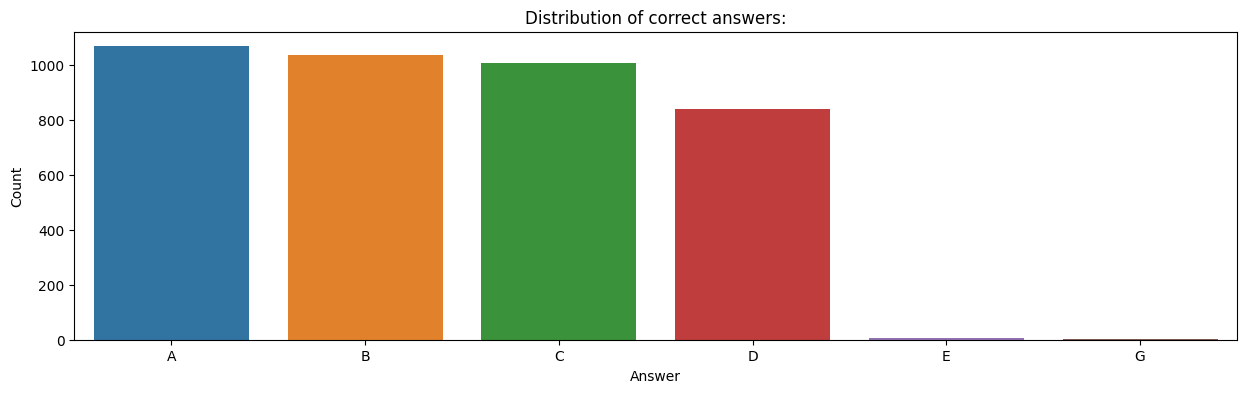

In [17]:
answer_dist = train_df_cleaned['answer'].value_counts()

plt.figure(figsize=(15, 4))
sns.barplot(x=answer_dist.index, y=answer_dist.values)
plt.title("Distribution of correct answers:")
plt.xlabel("Answer")
plt.ylabel("Count")
plt.show()

### We will need to reformat the input to prompts for finetuning Llama 3.2

In [18]:
# Ensure required columns are present in the train and test DataFrame
train_required_columns = ['task_id', 'question', 'choices', 'answer']
test_required_columns = ['task_id', 'question', 'choices']

for col1 in train_required_columns:
    train_df_cleaned[col1] = train_df_cleaned[col1].fillna('').astype(str)

for col2 in test_required_columns:
    test_df[col2] = test_df[col2].fillna('').astype(str)
    

<ipython-input-18-5b102a558b05>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned[col1] = train_df_cleaned[col1].fillna('').astype(str)
<ipython-input-18-5b102a558b05>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned[col1] = train_df_cleaned[col1].fillna('').astype(str)
<ipython-input-18-5b102a558b05>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [19]:
'''
Answer the following question by selecting the correct option:

Q: [Question]
Options:
A. [1st choice]
B. [2nd choice]
C. [3rd choice]
D. [4th choice]
etc.
'''
'''
A
'''
def create_prompt(row):
    # convert choices string to list (if any)
    try:
        if isinstance(row['choices'], str):
            choices_list = ast.literal_eval(row['choices'])
        else:
            choices_list = row['choices']
    except:
        choices_list = row['choices']
    
    # Create options part
    options = "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices_list)])
    
    # Create prompt
    prompt = f"""Answer the following question by selecting the correct option:

Q: {row['question']}
Options:
{options}"""
    
    return prompt


In [20]:
train_df_cleaned['prompt'] = train_df_cleaned.apply(create_prompt, axis=1)
test_df['prompt'] = test_df.apply(create_prompt, axis=1)


<ipython-input-20-16bedafc89a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned['prompt'] = train_df_cleaned.apply(create_prompt, axis=1)


In [21]:
train_df_cleaned.head()


,task_id,question,choices,answer,prompt
0,k10168,Question: What will be output of the following...,"['8 4 2', '8 4 2', '8 4 4', '8 4 3']",C,Answer the following question by selecting the...
1,k10173,Question: What will be output of the following...,"['-4', '-5', '10', '11']",A,Answer the following question by selecting the...
2,k10174,Question: Match the following.\n Group 1 ...,"['P-4. Q-1, R-2, S-3', 'P-3, Q-1, R-4, S-2', '...",B,Answer the following question by selecting the...
3,k10175,Question: Match the following.\nP. Regular exp...,"['P-4. Q-1, R-2, S-3', 'P-3, Q-1, R-4, S-2', '...",B,Answer the following question by selecting the...
4,k10176,Question: Which grammar rules violate the requ...,"['1 only', '1 and 3 only', '2 and 3 only', '3 ...",B,Answer the following question by selecting the...


In [22]:
print(test_df['prompt'][0])


Answer the following question by selecting the correct option:

Q: Question: What will be output of the following c code?
#include<stdio.h>
int main()
{
    int a= sizeof(signed) +sizeof(unsigned);
    int b=sizeof(const)+sizeof(volatile);
    printf("%d",a+++b);
    return 0;
}
Options:
A. 10
B. 9
C. 8
D. Error


In [23]:
# Split train_dataset into train and validation sets (80-20 split)
train_dataset = Dataset.from_pandas(train_df_cleaned)
split_datasets = train_dataset.train_test_split(test_size=0.2, seed=42)  # seed for reproducibility

train_dataset = split_datasets["train"]
valid_dataset = split_datasets["test"]
test_dataset = Dataset.from_pandas(test_df)


# Finetuning Llama 3.2 using CodeMMLU dataset

In [24]:
base_model = "/kaggle/input/llama-3.2/transformers/3b-instruct/1"
finetuned_model = "llama-3.2-3b-it-AIC2025-CodeMMLU"


In [25]:
# Set torch dtype and attention implementation
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
    torch_dtype = torch.float16
    attn_implementation = "eager"
    

In [26]:
# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)
# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
instruction = """You are an assistant chatbot that helps find the correct answer for multiple-choice programming questions.
    Only respond with the letter of the correct answer, without any explanation.
    """
def format_chat_template(row):
    row_json = [{"role": "system", "content": instruction},
               {"role": "user", "content": row["prompt"]},
               {"role": "assistant", "content": row["answer"]}]

    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

def format_test_chat_template(row):
    row_json = [{"role": "system", "content": instruction},
               {"role": "user", "content": row["prompt"]}]

    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False, add_generation_prompt=True)
    return row
    
train_dataset = train_dataset.map(
    format_chat_template,
    num_proc=4,
)
valid_dataset = valid_dataset.map(
    format_chat_template,
    num_proc=4,
)
test_dataset = test_dataset.map(
    format_test_chat_template,
    num_proc=4,
)


Map (num_proc=4):   0%|          | 0/3159 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/790 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1253 [00:00<?, ? examples/s]

In [28]:
print(train_dataset['text'][10])


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an assistant chatbot that helps find the correct answer for multiple-choice programming questions.
    Only respond with the letter of the correct answer, without any explanation.<|eot_id|><|start_header_id|>user<|end_header_id|>

Answer the following question by selecting the correct option:

Q: Question: Given a code snippet below, which behavior most likely to occur when execute it?
import java.util.ArrayList;
import java.util.Collections;
import java.util.List;
import java.util.Scanner;

public class Main {
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
        int n = sc.nextInt();
        int k = sc.nextInt();
        List<Long> list = new ArrayList<>();
        for(long i=0; i<n; i++) {
            list.add(sc.nextLong());
        }
        if(n <= k) {
            System.out.println(0);
            return;
        }
        Collections.sort(list);
        long total =

In [29]:
# Extract the linear model name from the model
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names: #needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

modules = find_all_linear_names(model)


In [30]:
# Use the linear module name to create LoRA adapter config since we just need to finetune the LoRA adapter
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)
# model, tokenizer = setup_chat_format(model, tokenizer)
model = get_peft_model(model, peft_config)


In [31]:
# Hyperparameter
training_arguments = SFTConfig(
    output_dir=finetuned_model,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    eval_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="wandb",
    packing=False,
    dataset_text_field="text",
    max_seq_length=512,
    label_names=["labels"]
)


In [32]:
# Add padding for tokenizer
tokenizer.pad_token = tokenizer.eos_token  
tokenizer.padding_side = "left"  


In [33]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,
)


Converting train dataset to ChatML:   0%|          | 0/3159 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/3159 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3159 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3159 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/790 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/790 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/790 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/790 [00:00<?, ? examples/s]

In [34]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
316,1.260700,0.811232
632,0.648100,0.758968
948,0.463000,0.743192
1264,0.844800,0.736266


TrainOutput(global_step=1579, training_loss=0.7231285821191112, metrics={'train_runtime': 2207.9015, 'train_samples_per_second': 1.431, 'train_steps_per_second': 0.715, 'total_flos': 1.1851795504945152e+16, 'train_loss': 0.7231285821191112})

In [35]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                 eval/loss █▃▂▁
wandb:  eval/mean_token_accuracy ▁▅▇█
wandb:           eval/num_tokens ▁▃▆█
wandb:              eval/runtime ▁█▅█
wandb:   eval/samples_per_second █▁▅▁
wandb:     eval/steps_per_second █▁▄▁
wandb:               train/epoch ▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
wandb:         train/global_step ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
wandb:           train/grad_norm █▄▅▇▂▄▇▆▇▂▅▅▇▅▁▅▅▆▄▃▅▆▂▅▃▇▂▃▇▂▇▅▃▃▇▇▂█▅▄
wandb:       train/learning_rate ▄▆███████▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
wandb:                train/loss ██▆▃█▆▂▃▅▃▄▄▁▅▆▂▄▆▆▂▃▁▂▃▄▄▃▃▅█▂▄▃▂▃▆▃▁▄▂
wandb: train/mean_token_accuracy ▁▆█▆▆▇▆▆▆▆▅▅▇▃▄▆▆▇▆▆▅▇▄▆▇▆▇▅▇▇▆▇▆█▆▇▅▆▄▃
wandb:          train/num_tokens ▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇███
wandb: 
wandb: Run summary:
wandb:                 eval/loss 0.73627
wandb:  eval/mean_token_accuracy 0.84057
wandb:           eval/num_tok

# Predicting the Test Dataset

In [36]:
# Testing
inputs = tokenizer(test_dataset["text"][0], return_tensors='pt', padding=True, truncation=True).to('cuda')

outputs = model.generate(**inputs, max_new_tokens=50, num_return_sequences=1)

text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(text.split("assistant")[1])
print()
print(text.split("assistant")[2][2])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 chatbot that helps find the correct answer for multiple-choice programming questions.
    Only respond with the letter of the correct answer, without any explanation.user

Answer the following question by selecting the correct option:

Q: Question: What will be output of the following c code?
#include<stdio.h>
int main()
{
    int a= sizeof(signed) +sizeof(unsigned);
    int b=sizeof(const)+sizeof(volatile);
    printf("%d",a+++b);
    return 0;
}
Options:
A. 10
B. 9
C. 8
D. Error

A


In [37]:
# Generating the answer
def generate_answer(row):
    inputs = tokenizer(row["text"], return_tensors='pt', padding=True, truncation=True).to('cuda')
    outputs = model.generate(**inputs, max_new_tokens=50, num_return_sequences=1)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = text.split("assistant")[2][2]

    row["answer"] = answer
    return row

test_dataset = test_dataset.map(
    generate_answer,
)


Map:   0%|          | 0/1253 [00:00<?, ? examples/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [38]:
# Creating the submission file
submission_file = test_dataset.select_columns(["task_id", "answer"])
submission_file = submission_file.to_pandas()
submission_file.head()

submission_file.to_csv("/kaggle/working/submission.csv", index=False)


In [39]:
# Save the fine-tuned model
trainer.model.save_pretrained(finetuned_model)
trainer.model.push_to_hub(finetuned_model, use_temp_dir=False)


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/97.3M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ferrum0404/llama-3.2-3b-it-AIC2025-CodeMMLU/commit/3d04589f0fb679fbe3ef59b4afd4cd9b7f3d7702', commit_message='Upload model', commit_description='', oid='3d04589f0fb679fbe3ef59b4afd4cd9b7f3d7702', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ferrum0404/llama-3.2-3b-it-AIC2025-CodeMMLU', endpoint='https://huggingface.co', repo_type='model', repo_id='ferrum0404/llama-3.2-3b-it-AIC2025-CodeMMLU'), pr_revision=None, pr_num=None)